In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
std=StandardScaler()
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


Enter dataset file name : covid_19_data
Enter format of the file "csv" or "excel" : csv


Enter the column name of the date : ObservationDate


Enter the format of the ObservationDate  : %m-%d-%Y


Enter the number of features you want to forecast ? : 1
Enter the name of the feature you want to forecast on : Confirmed


Do you want to forecast Confirmed on any category in the features (eg:- country(India)) or want to forecast Confirmed on whole (Yes/No) : No




Root Mean Square Error for ARIMA Model:  759278.724569136


Enter number of days to forecast ? :25


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




Root Mean Squared Error for Prophet Model:  32028.81722024812


Epoch 1/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0268
Epoch 2/30
102/102 [==============================] - 1s 9ms/step - loss: 1.6397e-04
Epoch 3/30
102/102 [==============================] - 1s 9ms/step - loss: 6.6673e-05
Epoch 4/30
102/102 [==============================] - 1s 9ms/step - loss: 7.1810e-05
Epoch 5/30
102/102 [==============================] - 1s 9ms/step - loss: 1.1810e-04
Epoch 6/30
102/102 [==============================] - 1s 9ms/step - loss: 1.0313e-04
Epoch 7/30
102/102 [==============================] - 1s 9ms/step - loss: 3.1426e-05
Epoch 8/30
102/102 [==============================] - 1s 8ms/step - loss: 4.3324e-05
Epoch 9/30
102/102 [==============================] - 0s 3ms/step - loss: 1.5206e-04
Epoch 10/30
102/102 [==============================] - 1s 12ms/step - loss: 2.7832e-04
Epoch 11/30
102/102 [==============================] - 1s 11ms/step - loss: 2.1373e-0

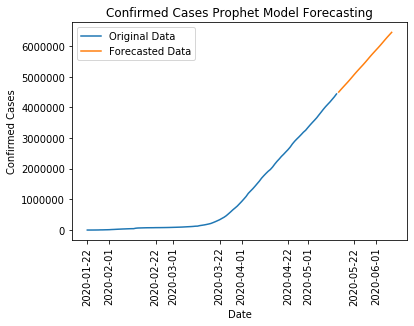

In [4]:
d1=str(input('Enter dataset file name : '))
d2=str(input('Enter format of the file "csv" or "excel" : ' ))
print('\n')
if d2=='csv':
    d1=d1+'.csv'
    d3=pd.read_csv(d1)
elif d2=='excel':
    d1=d1+'.xlsx'
    d3=pd.read_excel(d1) 
s1=str(input('Enter the column name of the date : '))
print('\n')
s2=str(input('Enter the format of the'+' '+s1+' '+' : ' ))
print('\n')
s3=int(input('Enter the number of features you want to forecast ? : '))
if s3==1:
    s4=str(input('Enter the name of the feature you want to forecast on : '))
    print('\n')
    d3[s1]=pd.to_datetime(d3[s1], format=s2, infer_datetime_format=True)
    
#Code to remove special characters and null values in the forecasting feature
    list1=[]
    list3=[]
    for i in range(len(d3[s4])):
        try:
            list1.append(int(d3[s4][i]))
        
        except:
            list3.append(i)
            continue
    for i in range(len(list3)):
        n2=d3[s4][list3[i]]
        d3[s4].replace(n2,np.nan,inplace=True)
    for i in range(len(d3)):
        d3[s4].fillna(d3[s4].median(),inplace=True)
d3[s4]=d3[s4].astype(int)

s5=str(input('Do you want to forecast'+' '+s4+' '+'on any category in the features (eg:- country(India)) or want to forecast'+' '+s4+' '+'on whole (Yes/No) : '))
print('\n')
if s5=='No':
    datewise=d3.groupby([s1]).agg({s4:'sum'})
elif s5=='Yes':
    s6=str(input('Enter the feature name from which who want to pick the category (eg:- country): '))
    s7=str(input('Ente the category name from'+' '+s6+' '+'to forecast'+' '+s4+' '+'  : '))
    s8=d3[d3[s6]==s7]
    datewise=s8.groupby([s1]).agg({s4:'sum'})
    
    
#Code for auto ARIMA

model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
valid1=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()
list4=[]
small=float('inf')
def augmented_dickey_fuller(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
augmented_dickey_fuller(datewise[s4])
if augmented_dickey_fuller(datewise[s4])[1]<0.05:
    datewise[s4]=datewise[s4]
elif augmented_dickey_fuller(datewise[s4])[1]>0.05:
    augmented_dickey_fuller(np.log(datewise[s4]))
    list4.append(augmented_dickey_fuller(np.log(datewise[s4]))[1])
    log_series=np.log(datewise[s4])
    diff1=(log_series.diff()).dropna()
    list4.append(augmented_dickey_fuller(diff1)[1])
    diff2=(diff1.diff()).dropna()
    list4.append(augmented_dickey_fuller(diff2)[1])
if len(list4)==0:
    d=0
    n1=datewise[s4]
elif len(list4)>0:
    if list4[0]<0.05:
        d=0
        n1=log_series
    elif list4[1]<0.05:
        d=1
        n1=diff1
    elif list4[2]<0.05:
        d=2
        n1=diff2
list5=[]
list7=[]
p = q = range(0, 4)
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(n1,order=param)
        results = mod.fit()
        list5.append(format(param))
        #list6.append(format(results.aic))
        list7.append(format(np.sum(np.square(results.resid))))
    except:
        continue
for i in range(len(list7)):
    list7[i]=float(list7[i])
small=float('inf')
for i in range(len(list7)):
    if list7[i]<small:
        small=list7[i]
n=list7.index(small)
s=list5[n]
p=int(s[1])
q=int(s[4])
#print(p,d,q)
list9=[]
n11=pd.infer_freq(datewise.index, warn=True)
if d==0 and len(list4)==0:
    model_arima=ARIMA(model_train[s4],(p,d,q))
    model_arima_fit=model_arima.fit()
    prediction_arima=model_arima_fit.forecast(len(valid))[0]
    #y_pred["ARIMA Model Prediction"]=list((prediction_arima))
    print('\n')
    print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(list(valid[s4]),(prediction_arima))))
    list9.append(np.sqrt(mean_squared_error(list(valid[s4]),np.exp(prediction_arima))))
    print('\n')
    t=int(input('Enter number of days to forecast ? :'))
    model_arima=ARIMA(datewise[s4],(p,d,q))
    model_arima_fit=model_arima.fit()
    forecast_arima = (model_arima_fit.predict(len(datewise),len(datewise)+t,typ='levels',dynamic=True).rename('ARIMA Forecast'))
    
elif d>=0 and len(list4)>0:
    model_arima=ARIMA(log_series,(p,d,q))
    model_arima_fit=model_arima.fit()
    prediction_arima=model_arima_fit.forecast(len(valid[s4]))[0]
    #y_pred["ARIMA Model Prediction"]=list(np.exp(prediction_arima))
    print('\n')
    print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(list(valid[s4]),np.exp(prediction_arima))))
    list9.append(np.sqrt(mean_squared_error(list(valid[s4]),np.exp(prediction_arima))))
    print('\n')
    t=int(input('Enter number of days to forecast ? :'))
    log_series=np.log(datewise)
    model_arima=ARIMA(log_series,(p,d,q))
    model_arima_fit=model_arima.fit()
    forecast_arima = np.exp(model_arima_fit.predict(len(log_series),len(log_series)+t,typ='levels'))
    
    
    
 #Code for FB PROPHET   
datewise1=datewise.reset_index()
datewise1.rename(columns={s1: 'ds',s4: 'y'},inplace=True)
train=datewise1.iloc[:int(datewise1.shape[0]*0.95)]
valid=datewise1.iloc[int(datewise1.shape[0]*0.95):]
m=Prophet(weekly_seasonality=True)
m.fit(train)
future=m.make_future_dataframe(periods=len(valid),freq=n11)
forecast=m.predict(future)
predictions=forecast.tail(len(valid))['yhat']
print('\n')
print("Root Mean Squared Error for Prophet Model: ",rmse(valid['y'],predictions))
print('\n')
list9.append(rmse(valid['y'],predictions))
m=Prophet(weekly_seasonality=True)
m.fit(datewise1)
future=m.make_future_dataframe(periods=t,freq=n11)
forecast=m.predict(future)
forecast_prophet=forecast[['ds','yhat']].tail(t)


#Code for LSTM


train=datewise.iloc[:int(datewise.shape[0]*0.95)]
test=datewise.iloc[int(datewise.shape[0]*0.95):]
scaler=MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)
n_input=len(test)
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)
model=Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit_generator(generator,epochs=30)
first_eval_batch=scaled_train[-n_input:]
test_predictions=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions=scaler.inverse_transform(test_predictions)
test['predictions']=true_predictions
list9.append(rmse(test[s4],test['predictions']))
print('\n')
print("Root Mean Square Error for LSTM Model: ", rmse(test[s4],test['predictions']))
print('\n')
train=datewise
scaler.fit(train)
train=scaler.transform(train)
n_input=len(test)
n_features=1
generator=TimeseriesGenerator(train,train,length=n_input,batch_size=1)
model.fit_generator(generator,epochs=30)
test_predictions=[]
first_eval_batch=train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))
for i in range(t):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
from pandas.tseries.offsets import DateOffset
add_dates=[datewise.index[-1]+DateOffset(months=x) for x in range(0,t+1)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=datewise.columns)
df_predict=pd.DataFrame(scaler.inverse_transform(test_predictions),index=future_dates[-t:].index,columns=['Confirmed'])
d_proj=df_predict
d_proj.reset_index(drop=True, inplace=True)
forecast_prophet.reset_index(drop=True, inplace=True) 
d1=pd.DataFrame(forecast_prophet['ds'])
lstm=pd.concat([d1,d_proj],axis=1)



#Choosing best model
print('\n')
t=str(t)
print('Forecasted Data of '+s4+' feature for '+t+ ' days : ' )
print('\n')
small=float('inf')
for i in range(len(list9)):
    if list9[i]<small:
        small=list9[i]
no=list9.index(small)
if no==0:
    print('Among ARIMA, FB PROPHET & LSTM : Arima is having the least RMSE & FORECAST is done based on ARIMA')
    forecast_arima=pd.DataFrame(forecast_arima)
    forecast_arima.reset_index(level=0, inplace=True)
    forecast_arima.rename(columns={'index':s1,0:s4},inplace=True)
    print(forecast_arima)
    forecast_arima = forecast_arima.set_index(s1)
    forecast_arima.apply(lambda x: '%.5f' % x, axis=1)
    plt.plot(datewise[s4],label="Original Data")
    plt.plot(forecast_arima[s4],label="Forecasted Data")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel('Confirmed Cases')
    plt.title("Confirmed Cases ARIMA Model Forecasting")
    plt.xticks(rotation=90)
    
elif no==1:
     print('Among ARIMA, FB PROPHET & LSTM : Prophet is having the least RMSE & FORECAST is done based on Prophet')
     forecast_prophet.rename(columns={'ds':s1,'yhat':s4},inplace=True)
     print(forecast_prophet)
     forecast_prophet = forecast_prophet.set_index(s1)
     plt.plot(datewise[s4],label="Original Data")
     plt.plot(forecast_prophet[s4],label="Forecasted Data")
     plt.legend()
     plt.xlabel("Date")
     plt.ylabel('Confirmed Cases')
     plt.title("Confirmed Cases Prophet Model Forecasting")
     plt.xticks(rotation=90)
elif no==2:
    print('Among ARIMA, FB PROPHET & LSTM : LSTM is having the least RMSE & FORECAST is done based on LSTM')
    lstm.rename(columns={'ds':s1,'yhat':s4},inplace=True)
    print(lstm)
    lstm = lstm.set_index(s1)
    plt.plot(datewise[s4],label="Original Data")
    plt.plot(lstm[s4],label="Forecasted Data")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel('Confirmed Cases')
    plt.title("Confirmed Cases LSTM Model Forecasting")
    plt.xticks(rotation=90)